In [ ]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.8 MB 1.3 MB/s 


In [ ]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn import svm
import xgboost as xgb
from sklearn.model_selection import GridSearchCV #optimze parameters
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.metrics import mean_squared_error as mse

In [ ]:
def get_list_from_filenames(file_path):
  lines=[Path(f).stem for f in glob.glob(file_path)]
  return lines

In [ ]:
def get_ypr_from_mat(mat_path):#get yaw,pitch,roll in radians
  mat=sio.loadmat(mat_path)
  pre_pose_params=mat['Pose_Para'][0]
  #get ypr
  pose_params=pre_pose_params[:3]
  return pose_params
    

In [ ]:
# Loading AFLW2000 Data
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

In [5]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

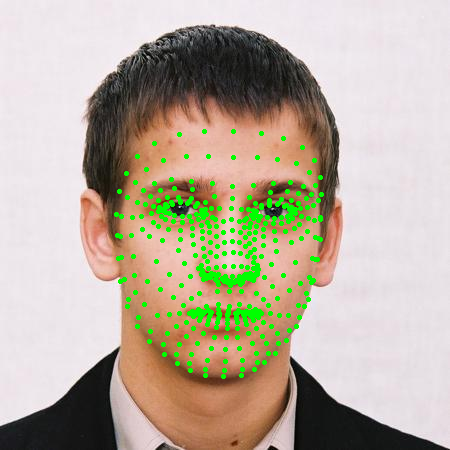

In [ ]:
# choosing random image
random_file = 'image00053'
ltest=[]
lfeatures=[]
faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              lfeatures.append(relative_x)
              lfeatures.append(relative_y)
      
              
              # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
      cv2_imshow(image)
      ltest.append(lfeatures)
      

dict_keys(['__header__', '__version__', '__globals__', 'pt2d', 'Illum_Para', 'Color_Para', 'Tex_Para', 'Shape_Para', 'Exp_Para', 'Pose_Para', 'roi', 'pt3d_68'])


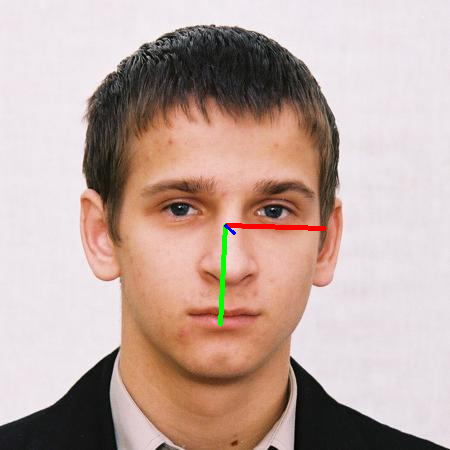

In [ ]:
image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/AFLW2000/'+random_file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
print(mat_file.keys())
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(image,pitch,yaw,roll))

In [6]:
def dataset_images_operations(imj_path):
    
    faceModule = mediapipe.solutions.face_mesh
    listxy=[]
    labels=[]
    c=0
    for imj in os.listdir(imj_path):
      
      if (imj.endswith('.jpg')):
        #print(c)
        # loading image and its correspinding mat file
        with faceModule.FaceMesh(static_image_mode=True) as faces:
        # loading the image
          image = cv2.imread('/content/AFLW2000/'+imj)
          # processing the face to extract the landmark points (468 point) for each x,y,z
          results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
          lfeatures=[]
          ylabels=[]
          if results.multi_face_landmarks != None: 
            # looping over the faces in the image
            for face in results.multi_face_landmarks:
                for landmark in face.landmark:
                    x = landmark.x
                    y = landmark.y
                    
                    # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                    shape = image.shape 
                    relative_x = int(x * shape[1])
                    relative_y = int(y * shape[0])
                    lfeatures.append(relative_x)
                    lfeatures.append(relative_y)
                    cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
            #cv2_imshow(image)
            listxy.append(lfeatures)
            mat_file = sio.loadmat('/content/AFLW2000/'+imj.split('.')[0]+'.mat')
            # extracting the labels 3 angels
            pose_para = mat_file["Pose_Para"][0][:3]
            pitch = pose_para[0]
            yaw = pose_para[1]
            roll = pose_para[2]
            ylabels.append(pitch)
            ylabels.append(yaw)
            ylabels.append(roll)
            #print(ylabels)
            labels.append(ylabels)
            #cv2_imshow(draw_axis(image,pitch,yaw,roll))
    return listxy,labels


**Convert points and labels to dataframe**

In [7]:
path="/content/AFLW2000/"
listxy,labels=dataset_images_operations(path)


In [8]:
df1=pd.DataFrame(labels)
df=pd.DataFrame(listxy)
df1.rename(columns={0:'pitch',1:'yaw',2:'roll'},inplace=True)
df3=pd.concat([df,df1],axis=1)
df3

,0,1,2,3,4,5,6,7,8,9,...,929,930,931,932,933,934,935,pitch,yaw,roll
0,269,323,285,277,261,294,256,240,286,264,...,206,241,209,261,190,261,186,0.225152,-0.858014,-0.263081
1,227,311,228,287,227,292,221,251,228,278,...,221,247,224,302,212,307,209,-0.331075,0.014285,0.067926
2,226,309,231,282,228,290,224,246,232,272,...,220,245,222,295,211,299,210,-0.252363,-0.085357,0.042692
3,235,286,255,273,240,275,250,251,258,267,...,233,247,236,255,232,256,230,-0.324275,-1.004428,0.431792
4,246,273,257,252,243,260,244,235,258,246,...,219,237,221,247,215,247,212,0.138026,-0.754013,-0.034957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,202,292,190,271,204,278,197,250,189,264,...,234,222,236,253,229,257,227,-0.320829,1.258194,-0.308974
1849,227,302,230,281,228,288,223,247,231,271,...,223,242,225,289,218,293,215,-0.095902,-0.078198,0.001859
1850,241,307,248,277,242,285,237,244,249,267,...,223,250,224,295,218,298,215,-0.041509,-0.216011,0.039515
1851,204,300,209,281,209,287,218,250,212,274,...,239,252,240,304,255,310,254,-0.173407,0.285409,0.461780


**Transform the points to be relative to the nose point**

In [9]:
def centeralize_imj(df4):
    df4.iloc[:,0::2]=df4.iloc[:,0::2].sub(df4[2],axis=0)
    df4.iloc[:,1::2]=df4.iloc[:,1::2].sub(df4[3],axis=0)
    return df4


In [10]:
df4=df3.copy()
df4=df4.drop(columns=['pitch','yaw','roll'],axis=1)
df4=centeralize_imj(df4)
df4

,0,1,2,3,4,5,6,7,8,9,...,926,927,928,929,930,931,932,933,934,935
0,-16,46,0,0,-24,17,-29,-37,1,-13,...,-49,-75,-48,-71,-44,-68,-24,-87,-24,-91
1,-1,24,0,0,-1,5,-7,-36,0,-9,...,26,-69,21,-66,19,-63,74,-75,79,-78
2,-5,27,0,0,-3,8,-7,-36,1,-10,...,22,-65,17,-62,14,-60,64,-71,68,-72
3,-20,13,0,0,-15,2,-5,-22,3,-6,...,-10,-42,-10,-40,-8,-37,0,-41,1,-43
4,-11,21,0,0,-14,8,-13,-17,1,-6,...,-22,-35,-22,-33,-20,-31,-10,-37,-10,-40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,12,21,0,0,14,7,7,-21,-1,-7,...,40,-39,36,-37,32,-35,63,-42,67,-44
1849,-3,21,0,0,-2,7,-7,-34,1,-10,...,18,-60,14,-58,12,-56,59,-63,63,-66
1850,-7,30,0,0,-6,8,-11,-33,1,-10,...,7,-55,3,-54,2,-53,47,-59,50,-62
1851,-5,19,0,0,0,6,9,-31,3,-7,...,52,-42,47,-42,43,-41,95,-26,101,-27


**Divide by euclidean distance to scale the centered points**

In [11]:
def standarize_imj(df4):
  scale=np.sqrt((df4[8]-df4[170])**2+(df4[9]-df4[171])**2)
  df4=df4.divide(scale,axis=0)
  return df4

In [12]:
df4=standarize_imj(df4)
df4

,0,1,2,3,4,5,6,7,8,9,...,926,927,928,929,930,931,932,933,934,935
0,-0.145370,0.417940,0.0,0.0,-0.218056,0.154456,-0.263484,-0.336169,0.009086,-0.118114,...,-0.445197,-0.681424,-0.436111,-0.645081,-0.399769,-0.617825,-0.218056,-0.790452,-0.218056,-0.826795
1,-0.017843,0.428230,0.0,0.0,-0.017843,0.089215,-0.124900,-0.642345,0.000000,-0.160586,...,0.463916,-1.231162,0.374701,-1.177633,0.339016,-1.124104,1.320376,-1.338219,1.409591,-1.391748
2,-0.091871,0.496102,0.0,0.0,-0.055122,0.146993,-0.128619,-0.661470,0.018374,-0.183742,...,0.404232,-1.194320,0.312361,-1.139198,0.257238,-1.102450,1.175946,-1.304565,1.249443,-1.322939
3,-0.376288,0.244587,0.0,0.0,-0.282216,0.037629,-0.094072,-0.413917,0.056443,-0.112887,...,-0.188144,-0.790206,-0.188144,-0.752577,-0.150515,-0.696133,0.000000,-0.771391,0.018814,-0.809020
4,-0.213683,0.407940,0.0,0.0,-0.271960,0.155406,-0.252534,-0.330237,0.019426,-0.116554,...,-0.427366,-0.679900,-0.427366,-0.641049,-0.388514,-0.602197,-0.194257,-0.718752,-0.194257,-0.777029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,0.276980,0.484716,0.0,0.0,0.323144,0.161572,0.161572,-0.484716,-0.023082,-0.161572,...,0.923268,-0.900186,0.830941,-0.854023,0.738615,-0.807860,1.454147,-0.969432,1.546474,-1.015595
1849,-0.048156,0.337091,0.0,0.0,-0.032104,0.112364,-0.112364,-0.545767,0.016052,-0.160520,...,0.288935,-0.963118,0.224727,-0.931014,0.192624,-0.898910,0.947066,-1.011274,1.011274,-1.059430
1850,-0.115235,0.493865,0.0,0.0,-0.098773,0.131697,-0.181084,-0.543251,0.016462,-0.164622,...,0.115235,-0.905419,0.049386,-0.888957,0.032924,-0.872494,0.773722,-0.971267,0.823108,-1.020654
1851,-0.094882,0.360550,0.0,0.0,0.000000,0.113858,0.170787,-0.588266,0.056929,-0.132834,...,0.986769,-0.797006,0.891887,-0.797006,0.815982,-0.778029,1.802751,-0.493384,1.916609,-0.512361


In [13]:
x=df4
y=df1
y


,pitch,yaw,roll
0,0.225152,-0.858014,-0.263081
1,-0.331075,0.014285,0.067926
2,-0.252363,-0.085357,0.042692
3,-0.324275,-1.004428,0.431792
4,0.138026,-0.754013,-0.034957
...,...,...,...
1848,-0.320829,1.258194,-0.308974
1849,-0.095902,-0.078198,0.001859
1850,-0.041509,-0.216011,0.039515
1851,-0.173407,0.285409,0.461780


split data into training and testing

In [14]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
y_test

,pitch,yaw,roll
1427,0.392175,0.691749,0.151684
1767,-0.123677,-0.246394,0.092440
219,-0.017282,-0.623240,0.098033
1430,0.012390,-0.512611,0.029883
227,-0.197102,-0.070430,0.105118
...,...,...,...
910,-0.297849,-0.202252,0.193086
63,0.075204,-0.243854,-0.162533
391,-0.035426,-0.058997,-0.104905
1762,0.101413,0.066464,-0.005796


Train the model to predict pitch

using svr

In [15]:
pitch_sv=svm.SVR()
pitch_sv.fit(x_train,y_train['pitch'])


SVR()

test the model

In [16]:
pitch_sv.score(x_test,y_test['pitch'])
yp_test=pitch_sv.predict(x_test)
print('mse in pitch using svr=',mse(y_test['pitch'],yp_test))

print('r2 in pitch using svr=',pitch_sv.score(x_test,y_test['pitch']))

mse in pitch using svr= 0.01870554753056753
r2 in pitch using svr= 0.7553864302706492


using random forest

In [ ]:
randf=rf()
randf.fit(x_train,y_train['pitch'])
yp_test=randf.predict(x_test)
print('mse in pitch using randomforest=',mse(y_test['pitch'],yp_test))
print('r2 in pitch using rf=',randf.score(x_test,y_test['pitch']))

mse in pitch using randomforest= 0.7333430607648805
r2 in pitch using rf= 0.013597881416961832


Train the model to predict yaw

In [17]:
#yaw_xg=xgb.XGBRegressor()
yaw_sv=svm.SVR()
param={'n_estimators':[15,50,100],
       'max_depth':[5,10,20],
       'learning_rate':[0.001,0.1,0.01]   
}
yaw_sv.fit(x_train,y_train['yaw'])


SVR()

test the model

In [18]:


yp_test=yaw_sv.predict(x_test)
print('mse in yaw using xgboost=',mse(y_test['yaw'],yp_test))
print('r2 in yaw using xgboost=',yaw_sv.score(x_test,y_test['yaw']))


mse in yaw using xgboost= 0.01805751484769887
r2 in yaw using xgboost= 0.9380388758224071


Train the model to predict roll

using xgboost

In [ ]:
xg2=xgb.XGBRegressor()
param={'n_estimators':[15,50,100],
       'max_depth':[5,10,20],
       'learning_rate':[0.001,0.1,0.01]   
}
xg2.fit(x_train,y_train['roll'])

[01:39:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

Test the model

In [ ]:

yp_test=xg2.predict(x_test)
print('mse in roll using xgboost=',mse(y_test['roll'],yp_test))
print('r2 in roll using xgboost=',xg2.score(x_test,y_test['roll']))

mse in roll using xgboost= 0.685003757417396
r2 in roll using xgboost= 0.18559078248338845


use svr

In [19]:
roll_sv=svm.SVR()
roll_sv.fit(x_train,y_train['roll'])

yp_test=roll_sv.predict(x_test)
print('mse in roll using svr=',mse(y_test['roll'],yp_test))
print('r2 in roll using svr=',roll_sv.score(x_test,y_test['roll']))


mse in roll using svr= 0.018772430343734714
r2 in roll using svr= 0.8076201828924092


Test on a video

In [85]:
def video_reading(video_path):
  videocap=cv2.VideoCapture(video_path)
  success,image=videocap.read()
  fw = int(videocap.get(3))
  fh= int(videocap.get(4))
  fps=int(videocap.get(cv2.CAP_PROP_FPS))

  vid=cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc('M','J','P','G'),fps,(fw,fh))
  count=0
  
  while success:
    #cv2.imwrite("/content/sample_data/Fr/frame%d.jpg"%count,image)

    ypred=[]
    success,image=videocap.read()
    print("read a new frame:",success)
    #transform imj
    features,image=test_imj(image,verbose=1)
    features=pd.DataFrame(features).T
    f=features.copy()
    origx=f[2]
    origy=f[3]
    print(origx)
    print(origy)
    c_features=centeralize_imj(features)
    imj_transf=standarize_imj(c_features)
    pitch=pitch_sv.predict(imj_transf)
    yaw=yaw_sv.predict(imj_transf)
    roll=roll_sv.predict(imj_transf)
    print(origx)
    image_mod=draw_axis(image,pitch,yaw,roll,float(origx),float(origy))
    vid.write(image_mod)
    cv2_imshow(image_mod)
    count+=1
    if count==210:
      break
  videocap.release()
  vid.release()  
 


read a new frame: True
0    184
Name: 2, dtype: int64
0    223
Name: 3, dtype: int64
0    184
Name: 2, dtype: int64


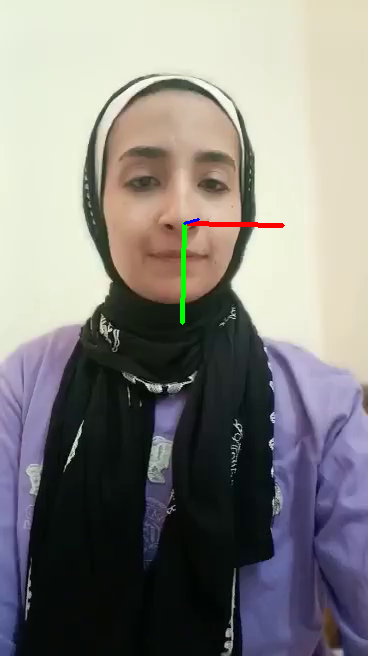

read a new frame: True
0    184
Name: 2, dtype: int64
0    224
Name: 3, dtype: int64
0    184
Name: 2, dtype: int64


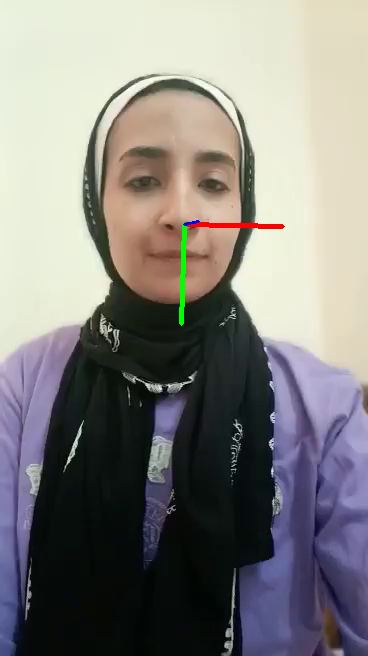

read a new frame: True
0    184
Name: 2, dtype: int64
0    228
Name: 3, dtype: int64
0    184
Name: 2, dtype: int64


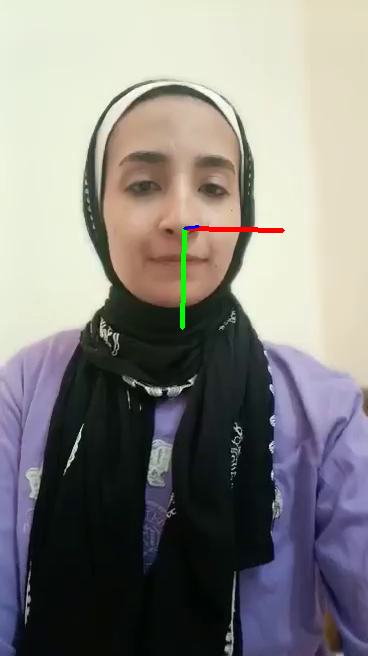

read a new frame: True
0    184
Name: 2, dtype: int64
0    229
Name: 3, dtype: int64
0    184
Name: 2, dtype: int64


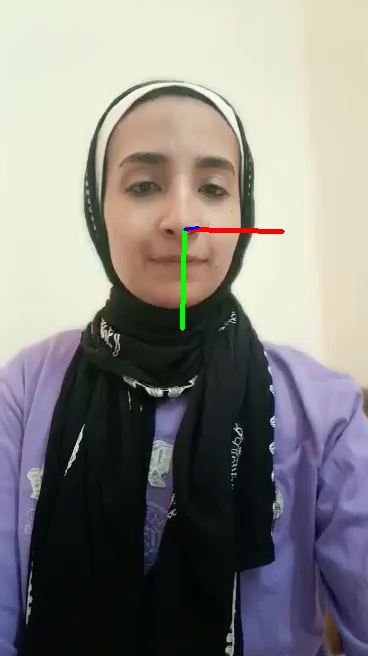

read a new frame: True
0    183
Name: 2, dtype: int64
0    229
Name: 3, dtype: int64
0    183
Name: 2, dtype: int64


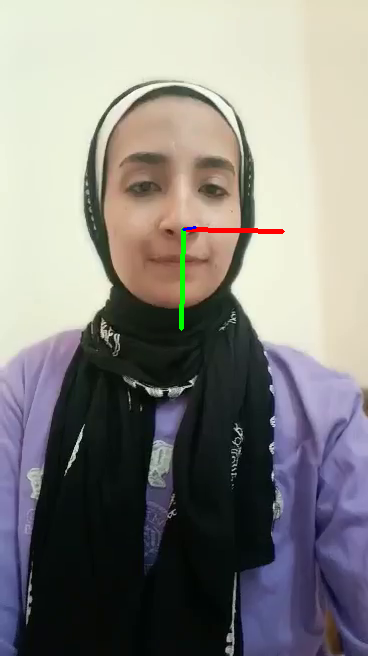

read a new frame: True
0    184
Name: 2, dtype: int64
0    226
Name: 3, dtype: int64
0    184
Name: 2, dtype: int64


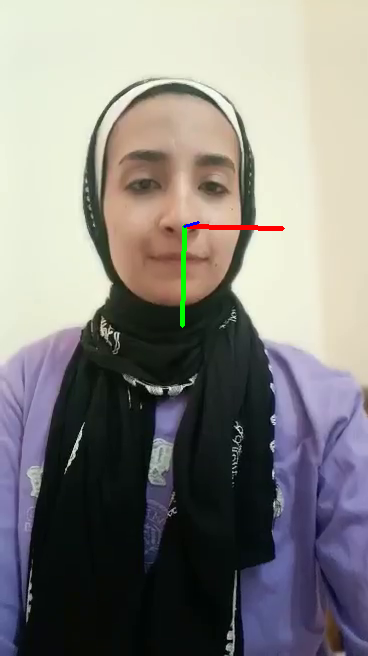

read a new frame: True
0    184
Name: 2, dtype: int64
0    226
Name: 3, dtype: int64
0    184
Name: 2, dtype: int64


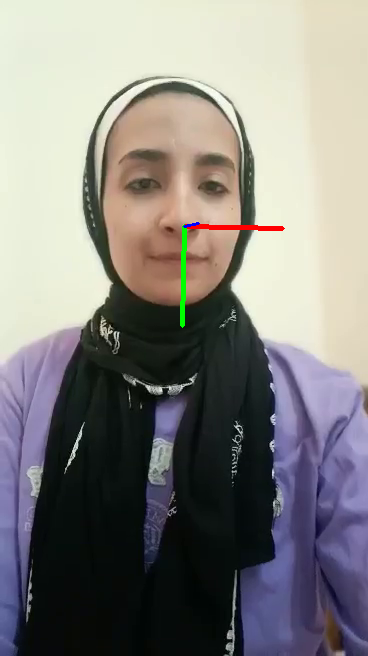

read a new frame: True
0    184
Name: 2, dtype: int64
0    226
Name: 3, dtype: int64
0    184
Name: 2, dtype: int64


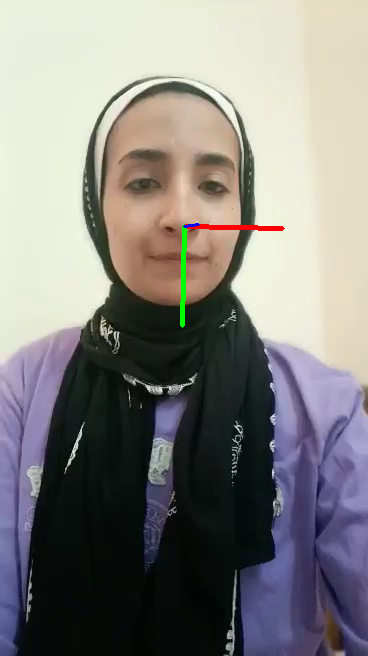

read a new frame: True
0    184
Name: 2, dtype: int64
0    225
Name: 3, dtype: int64
0    184
Name: 2, dtype: int64


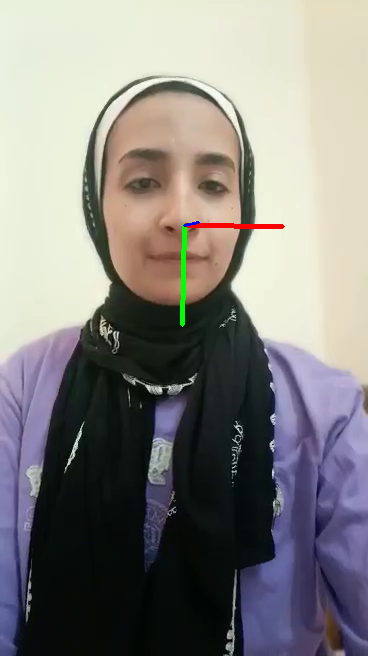

read a new frame: True
0    184
Name: 2, dtype: int64
0    226
Name: 3, dtype: int64
0    184
Name: 2, dtype: int64


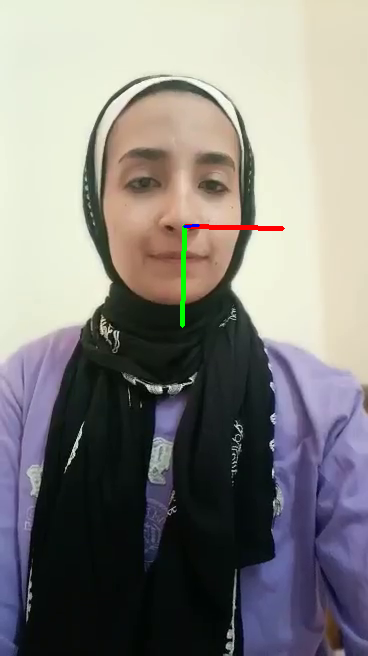

read a new frame: True
0    186
Name: 2, dtype: int64
0    225
Name: 3, dtype: int64
0    186
Name: 2, dtype: int64


In [ ]:
video_reading("/content/sample_data/alaa's.mp4")

In [25]:
def test_imj(imj,verbose=0):
        if verbose==1:
          image=imj
        else:
           # loading the image
          image = cv2.imread(imj)
          
        faceModule = mediapipe.solutions.face_mesh
        lfeatures=[]
        with faceModule.FaceMesh(static_image_mode=True) as faces:
       
          # processing the face to extract the landmark points (468 point) for each x,y,z
          results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
         
          
          if results.multi_face_landmarks != None: 
            # looping over the faces in the image
            for face in results.multi_face_landmarks:
                for landmark in face.landmark:
                    x = landmark.x
                    y = landmark.y
                    
                    # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                    shape = image.shape 
                    relative_x = int(x * shape[1])
                    relative_y = int(y * shape[0])
                    lfeatures.extend([relative_x,relative_y])
                    
                
        return lfeatures,image

In [76]:
#transform imj
features,image=test_imj('/content/sample_data/mickey.jpg')
features=pd.DataFrame(features).T
f=features.copy()
origx=f[2]
origy=f[3]
print(origx)
print(origy)


0    242
Name: 2, dtype: int64
0    190
Name: 3, dtype: int64


Test image

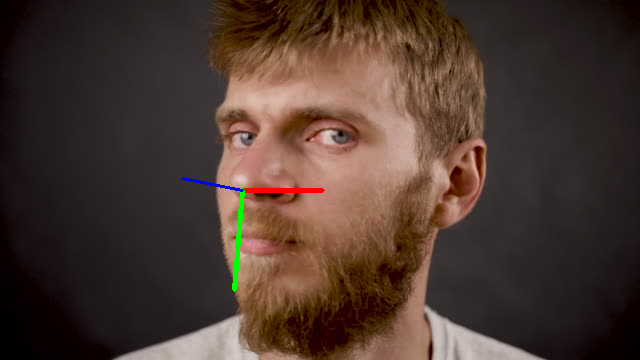

In [77]:
c_features=centeralize_imj(features)
imj_transf=standarize_imj(c_features)
pitch=pitch_sv.predict(imj_transf)
yaw=yaw_sv.predict(imj_transf)
roll=roll_sv.predict(imj_transf)

cv2_imshow(draw_axis(image,pitch,yaw,roll,242,190))
